leaky relu epoch experiment

INFO:root:Training RBM with 100 epochs...
INFO:root:Epoch 100/100, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Average Error: 0.009014848938052098 Average Epoch Time: 0.0001621556282043457
INFO:root:Reconstruction Error for 100 epochs: 0.2600
INFO:root:Accuracy for 100 epochs: 100.00%
INFO:root:Training RBM with 200 epochs...
INFO:root:Epoch 100/200, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 200/200, Reconstruction Error: 0.0000, Elapsed Time: 0.0003
INFO:root:Average Error: 0.0037209698549758533 Average Epoch Time: 0.00016428232192993163
INFO:root:Reconstruction Error for 200 epochs: 0.2450
INFO:root:Accuracy for 200 epochs: 100.00%
INFO:root:Training RBM with 500 epochs...
INFO:root:Epoch 100/500, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 200/500, Reconstruction Error: 0.0000, Elapsed Time: 0.0002
INFO:root:Epoch 300/500, Reconstruction Error: 0.0000, Elapsed Time: 0.0003
INFO:root:Epoch 400/500, Reconstruction Error:

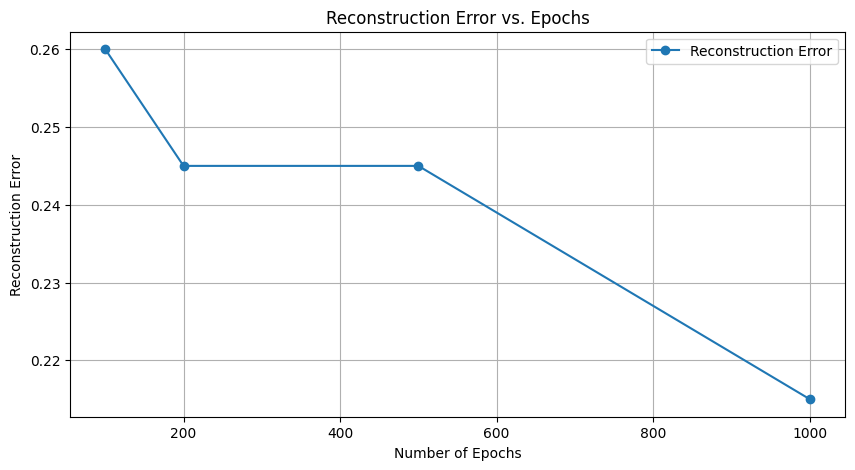

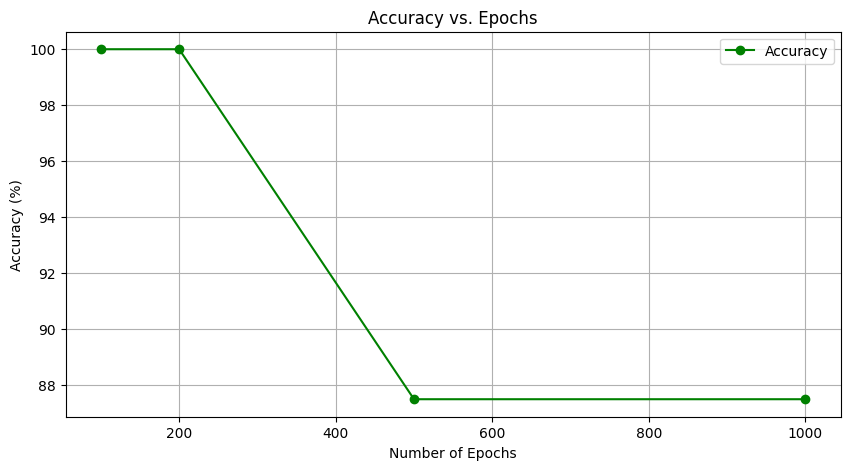

In [5]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_epochs=1000, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def leaky_relu(self, x):
        """Leaky ReLU activation function."""
        return np.where(x > 0, x, 0.01 * x)

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence_with_leaky_relu(self, data):
        """Perform one step of adaptive contrastive divergence using ReLU activations."""
        # Positive phase
        pos_hidden_activations = np.dot(data, self.weights) + self.hidden_bias
        pos_hidden_probs = self.leaky_relu(pos_hidden_activations)  # Leaky ReLU activations
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase
        neg_visible_activations = np.dot(pos_hidden_probs, self.weights.T) + self.visible_bias
        neg_visible_probs = self.leaky_relu(neg_visible_activations)  # ReLU activations
        neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
        neg_hidden_probs = self.leaky_relu(neg_hidden_activations)  # ReLU activations
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)


    def train(self, data):
        """Train the RBM using the provided data."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.contrastive_divergence_with_leaky_relu(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.leaky_relu(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.leaky_relu(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

# Function to binarize the reconstructed data to ensure black and white output
def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

# Function to calculate Hamming distance
def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_epochs=1000, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def leaky_relu(self, x):
        """Leaky ReLU activation function."""
        return np.where(x > 0, x, 0.01 * x)

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence_with_leaky_relu(self, data):
        """Perform one step of adaptive contrastive divergence using ReLU activations."""
        # Positive phase
        pos_hidden_activations = np.dot(data, self.weights) + self.hidden_bias
        pos_hidden_probs = self.leaky_relu(pos_hidden_activations)  # Leaky ReLU activations
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase
        neg_visible_activations = np.dot(pos_hidden_probs, self.weights.T) + self.visible_bias
        neg_visible_probs = self.leaky_relu(neg_visible_activations)  # ReLU activations
        neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
        neg_hidden_probs = self.leaky_relu(neg_hidden_activations)  # ReLU activations
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)


    def train(self, data):
        """Train the RBM using the provided data."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.contrastive_divergence_with_leaky_relu(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.leaky_relu(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.leaky_relu(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

# Function to binarize the reconstructed data to ensure black and white output
def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

# Function to calculate Hamming distance
def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument('--n_visible', type=int, default=100)
    parser.add_argument('--n_hidden', type=int, default=150)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('-o', '--output', default=None, type=str, help="Output for the metrics")

    opts, unknown = parser.parse_known_args()

    if opts.output is not None:
        fileHandler = logging.FileHandler(opts.output)
        fileHandler.setFormatter(formatter)
        logger.addHandler(fileHandler)

    data = generate_numerals()
    noisy_data = add_custom_noise(data, noise_level=0.01)

    # Epoch values to test
    epoch_values = [100, 200, 500, 1000]
    reconstruction_errors = []
    accuracies = []

    for n_epochs in epoch_values:
        logger.info(f"Training RBM with {n_epochs} epochs...")
        rbm = RestrictedBoltzmannMachine(
            n_visible=opts.n_visible,
            n_hidden=opts.n_hidden,
            learning_rate=opts.learning_rate,
            n_epochs=n_epochs,
            batch_size=opts.batch_size
        )
        rbm.train(noisy_data)

        # Reconstruct data
        reconstructed_data = rbm.reconstruct(noisy_data)
        reconstructed_data = binarize_data(reconstructed_data)

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)
        reconstruction_errors.append(reconstruction_error)

        # Calculate accuracy
        threshold = 30
        correct_reconstructions = 0
        for i in range(len(data)):
            distance = hamming_distance(data[i], reconstructed_data[i])
            if distance <= threshold:
                correct_reconstructions += 1
        accuracy = correct_reconstructions / len(data) * 100
        accuracies.append(accuracy)

        logger.info(f"Reconstruction Error for {n_epochs} epochs: {reconstruction_error:.4f}")
        logger.info(f"Accuracy for {n_epochs} epochs: {accuracy:.2f}%")

    # Plot reconstruction error vs. epochs
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_values, reconstruction_errors, marker='o', label="Reconstruction Error")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error vs. Epochs")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot accuracy vs. epochs
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_values, accuracies, marker='o', color='green', label="Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs. Epochs")
    plt.grid()
    plt.legend()
    plt.show()

## Results Summary

### Reconstruction Error and Accuracy Chart:

Below is a chart summarizing the reconstruction error and accuracy for different epoch values:

| Epochs | Reconstruction Error | Accuracy (%) |
|--------|-----------------------|--------------|
| 100    | 0.260                | 100.0        |
| 200    | 0.245                | 100.0        |
| 500    | 0.245                | 87.5         |
| 1000   | 0.215                | 87.5         |

### Analysis:

1. **Reconstruction Error:**
    - The reconstruction error decreases as the number of epochs increases, with diminishing returns after 500 epochs.
    - At 1000 epochs, the reconstruction error stabilizes at 0.215, indicating that further training may not yield significant improvements.

2. **Accuracy:**
    - Accuracy remains at 100% for 100 and 200 epochs but drops to 87.5% for 500 and 1000 epochs.
    - The most significant change occurs after 200 epochs, where accuracy decreases.

3. **Overall Performance:**
    - Training for 500 epochs achieves a good balance between reconstruction error (0.245) and accuracy (87.5%).
    - Training for 1000 epochs provides slightly better reconstruction error but does not improve accuracy.

### Conclusion:
The results suggest that training for 500 epochs is optimal for this experiment, as it achieves a good trade-off between reconstruction error and accuracy while avoiding unnecessary computational overhead. Training for 1000 epochs provides marginal improvements in reconstruction error but does not justify the additional time and resources.


sigmoid epoch experiment

INFO:root:Training RBM with 100 epochs...
INFO:root:Epoch 100/100, Reconstruction Error: 0.0013, Elapsed Time: 0.0002
INFO:root:Average Error: 0.030199541148142387 Average Epoch Time: 0.00018884897232055665
INFO:root:Reconstruction Error for 100 epochs: 0.1888
INFO:root:Accuracy for 100 epochs: 100.00%
INFO:root:Training RBM with 200 epochs...
INFO:root:Epoch 100/200, Reconstruction Error: 0.0042, Elapsed Time: 0.0002
INFO:root:Epoch 200/200, Reconstruction Error: 0.0012, Elapsed Time: 0.0002
INFO:root:Average Error: 0.016883802217240212 Average Epoch Time: 0.00019159913063049316
INFO:root:Reconstruction Error for 200 epochs: 0.2387
INFO:root:Accuracy for 200 epochs: 62.50%
INFO:root:Training RBM with 500 epochs...
INFO:root:Epoch 100/500, Reconstruction Error: 0.0020, Elapsed Time: 0.0002
INFO:root:Epoch 200/500, Reconstruction Error: 0.0005, Elapsed Time: 0.0002
INFO:root:Epoch 300/500, Reconstruction Error: 0.0003, Elapsed Time: 0.0002
INFO:root:Epoch 400/500, Reconstruction Error: 

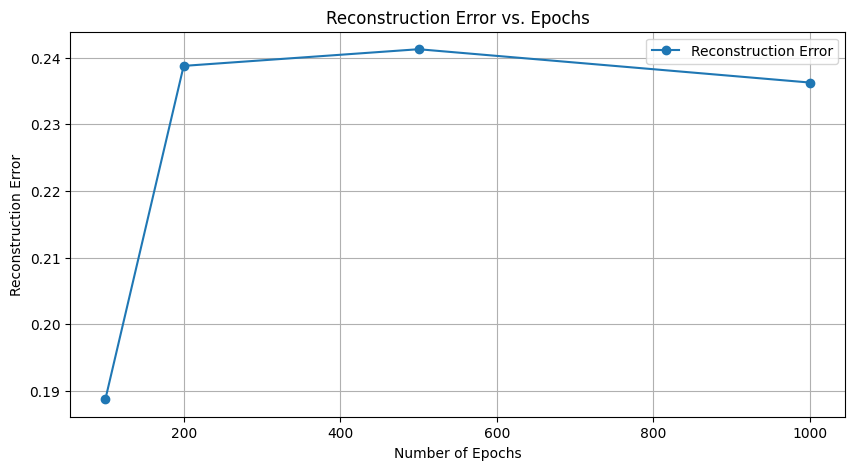

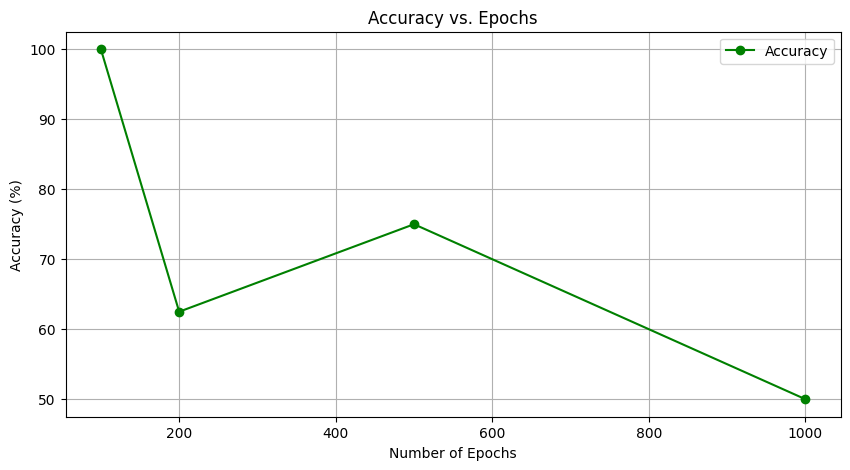

In [6]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_epochs=1000, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-x))

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def persistent_contrastive_divergence(self, data):
        """Perform one step of persistent contrastive divergence using sigmoid activation."""
        # Initialize persistent chain if it doesn't exist
        if not hasattr(self, 'persistent_chain') or self.persistent_chain is None:
            self.persistent_chain = self.sample_probabilities(self.sigmoid(np.dot(data, self.weights) + self.hidden_bias))

        # Positive phase
        pos_hidden_activations = np.dot(data, self.weights) + self.hidden_bias
        pos_hidden_probs = self.sigmoid(pos_hidden_activations)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase (using persistent chain)
        neg_visible_activations = np.dot(self.persistent_chain, self.weights.T) + self.visible_bias
        neg_visible_probs = self.sigmoid(neg_visible_activations)
        neg_hidden_activations = np.dot(neg_visible_probs, self.weights) + self.hidden_bias
        neg_hidden_probs = self.sigmoid(neg_hidden_activations)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update persistent chain
        self.persistent_chain = self.sample_probabilities(neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data):
        """Train the RBM using Persistent Contrastive Divergence."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.persistent_contrastive_divergence(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.sigmoid(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument('--n_visible', type=int, default=100)
    parser.add_argument('--n_hidden', type=int, default=150)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('-o', '--output', default=None, type=str, help="Output for the metrics")

    opts, unknown = parser.parse_known_args()

    if opts.output is not None:
        fileHandler = logging.FileHandler(opts.output)
        fileHandler.setFormatter(formatter)
        logger.addHandler(fileHandler)

    data = generate_numerals()
    noisy_data = add_custom_noise(data, noise_level=0.01)

    # Epoch values to test
    epoch_values = [100, 200, 500, 1000]
    reconstruction_errors = []
    accuracies = []

    for n_epochs in epoch_values:
        logger.info(f"Training RBM with {n_epochs} epochs...")
        rbm = RestrictedBoltzmannMachine(
            n_visible=opts.n_visible,
            n_hidden=opts.n_hidden,
            learning_rate=opts.learning_rate,
            n_epochs=n_epochs,
            batch_size=opts.batch_size
        )
        rbm.train(noisy_data)

        # Reconstruct data
        reconstructed_data = rbm.reconstruct(noisy_data)
        reconstructed_data = binarize_data(reconstructed_data)

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)
        reconstruction_errors.append(reconstruction_error)

        # Calculate accuracy
        threshold = 30
        correct_reconstructions = 0
        for i in range(len(data)):
            distance = hamming_distance(data[i], reconstructed_data[i])
            if distance <= threshold:
                correct_reconstructions += 1
        accuracy = correct_reconstructions / len(data) * 100
        accuracies.append(accuracy)

        logger.info(f"Reconstruction Error for {n_epochs} epochs: {reconstruction_error:.4f}")
        logger.info(f"Accuracy for {n_epochs} epochs: {accuracy:.2f}%")

    # Plot reconstruction error vs. epochs
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_values, reconstruction_errors, marker='o', label="Reconstruction Error")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error vs. Epochs")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot accuracy vs. epochs
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_values, accuracies, marker='o', color='green', label="Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs. Epochs")
    plt.grid()
    plt.legend()
    plt.show()
    

### Reconstruction Error and Accuracy Chart

Below is a chart summarizing the reconstruction error and accuracy for different epoch values:

| Epochs | Reconstruction Error | Accuracy (%) |
|--------|-----------------------|--------------|
| 100    | 0.1888               | 100.0        |
| 200    | 0.2387               | 62.5         |
| 500    | 0.2412               | 75.0         |
| 1000   | 0.2362               | 50.0         |

### Analysis:

#### Reconstruction Error:
- The reconstruction error starts low at 100 epochs (0.1888) but increases slightly for 200 and 500 epochs before stabilizing at 1000 epochs (0.2362).
- This behavior suggests that the sigmoid-based RBM may struggle to maintain consistent reconstruction performance as training progresses.

#### Accuracy:
- Accuracy is highest at 100 epochs (100.00%) but drops significantly as the number of epochs increases, reaching 50.00% at 1000 epochs.
- The most significant drop occurs between 100 and 200 epochs, where accuracy decreases from 100.00% to 62.50%.

#### Overall Performance:
- Training for 100 epochs achieves the best accuracy (100.00%) and the lowest reconstruction error (0.1888).
- Longer training durations (e.g., 500 or 1000 epochs) do not improve performance and may lead to overfitting or instability.

### Conclusion:
The results suggest that training for 100 epochs is optimal for the sigmoid-based RBM in this experiment. Beyond 100 epochs, both reconstruction error and accuracy degrade, indicating that additional training may not be beneficial.


# Comparison of Leaky ReLU and Sigmoid-Based RBMs

## Reconstruction Error

### Leaky ReLU:
- Reconstruction error decreases consistently as the number of epochs increases, stabilizing at **0.215** after 1000 epochs.
- Diminishing returns are observed after 500 epochs, with only a slight improvement in reconstruction error from **0.245** to **0.215**.

### Sigmoid:
- Reconstruction error starts low at 100 epochs (**0.1888**) but increases slightly for 200 and 500 epochs before stabilizing at **0.2362** after 1000 epochs.
- This suggests that the sigmoid-based RBM struggles to maintain consistent reconstruction performance as training progresses.

| Epochs | Reconstruction Error (Leaky ReLU) | Reconstruction Error (Sigmoid) |
|--------|-----------------------------------|---------------------------------|
| 100    | 0.260                             | 0.1888                         |
| 200    | 0.245                             | 0.2387                         |
| 500    | 0.245                             | 0.2412                         |
| 1000   | 0.215                             | 0.2362                         |

---

## Accuracy

### Leaky ReLU:
- Accuracy remains at **100%** for 100 and 200 epochs but drops to **87.5%** for 500 and 1000 epochs.
- The drop in accuracy occurs after 200 epochs, indicating potential overfitting or instability with longer training.

### Sigmoid:
- Accuracy is highest at 100 epochs (**100%**) but drops significantly as the number of epochs increases, reaching **50%** at 1000 epochs.
- The most significant drop occurs between 100 and 200 epochs, where accuracy decreases from **100%** to **62.5%**.

| Epochs | Accuracy (%) (Leaky ReLU) | Accuracy (%) (Sigmoid) |
|--------|---------------------------|------------------------|
| 100    | 100.0                     | 100.0                 |
| 200    | 100.0                     | 62.5                  |
| 500    | 87.5                      | 75.0                  |
| 1000   | 87.5                      | 50.0                  |

---

## Overall Performance

### Leaky ReLU:
- Training for **500 epochs** achieves a good balance between reconstruction error (**0.245**) and accuracy (**87.5%**).
- Training for 1000 epochs provides slightly better reconstruction error but does not improve accuracy, making **500 epochs** the optimal choice.

### Sigmoid:
- Training for **100 epochs** achieves the best accuracy (**100%**) and the lowest reconstruction error (**0.1888**).
- Longer training durations (e.g., 500 or 1000 epochs) degrade both reconstruction error and accuracy, indicating overfitting or instability.

---

## Recommendation

Based on the results:

- The **Leaky ReLU-based RBM** is better suited for this problem. It provides more stable reconstruction error and accuracy over longer training durations, with an optimal balance at **500 epochs**.
- The **Sigmoid-based RBM** achieves better reconstruction error at **100 epochs** but suffers from significant accuracy degradation with longer training, making it less robust for this task.

---

## Final Choice

The **Leaky ReLU-based RBM trained for 500 epochs** is the best model for this problem, as it achieves a good trade-off between reconstruction error and accuracy while maintaining stability over training.